In [34]:
from pydantic import BaseModel

class Vector3(BaseModel):
    x: float
    y: float
    z: float

class SceneObject(BaseModel):
    name: str
    position: Vector3
    size: Vector3
    rotation_euler_angles_degrees: Vector3

class Scene(BaseModel):
    stable_diffusion_scene_skybox_prompt: str
    objects: list[SceneObject]

In [35]:
from openai import OpenAI

client = OpenAI()

response = client.responses.parse(
    model="gpt-4o-2024-08-06",
    input=[
        {
            "role": "system",
            "content": "Imagine a scene based on the prompt with some objects in the scene. Extract the scene information. Ensure the prompt for the scene skybox could generate a skybox image that could be used on a spherical shader. Add as many objects to the scene as needed, multiple copies of the same object are cheap and easy to do.",
        },
        {
            "role": "user",
            "content": "Space",
        },
    ],
    text_format=Scene,
)

scene = response.output_parsed
print(scene)

stable_diffusion_scene_skybox_prompt='A vast expanse of deep space, filled with distant stars and nebulae glowing in vibrant colors. The scene is dominated by a large spiral galaxy swirling in the distance, with a few bright planets visible against a backdrop of countless twinkling stars.' objects=[SceneObject(name='Spacecraft', position=Vector3(x=0.0, y=0.0, z=-10.0), size=Vector3(x=2.0, y=1.0, z=4.0), rotation_euler_angles_degrees=Vector3(x=0.0, y=45.0, z=0.0)), SceneObject(name='Asteroid', position=Vector3(x=5.0, y=3.0, z=-15.0), size=Vector3(x=1.0, y=1.0, z=1.0), rotation_euler_angles_degrees=Vector3(x=20.0, y=10.0, z=0.0)), SceneObject(name='Asteroid', position=Vector3(x=-3.0, y=-2.0, z=-5.0), size=Vector3(x=1.5, y=1.5, z=1.5), rotation_euler_angles_degrees=Vector3(x=0.0, y=30.0, z=10.0)), SceneObject(name='Satellite', position=Vector3(x=-4.0, y=1.0, z=-8.0), size=Vector3(x=0.5, y=0.5, z=1.0), rotation_euler_angles_degrees=Vector3(x=15.0, y=0.0, z=45.0)), SceneObject(name='Space D

In [36]:
scene_json = scene.model_dump_json(indent=4)
with open("./Unity/AIML Research Project/Assets/scene.json", "w") as scene_file:
    scene_file.write(scene_json)

In [38]:
print(scene_json)

{
    "stable_diffusion_scene_skybox_prompt": "A vast expanse of deep space, filled with distant stars and nebulae glowing in vibrant colors. The scene is dominated by a large spiral galaxy swirling in the distance, with a few bright planets visible against a backdrop of countless twinkling stars.",
    "objects": [
        {
            "name": "Spacecraft",
            "position": {
                "x": 0.0,
                "y": 0.0,
                "z": -10.0
            },
            "size": {
                "x": 2.0,
                "y": 1.0,
                "z": 4.0
            },
            "rotation_euler_angles_degrees": {
                "x": 0.0,
                "y": 45.0,
                "z": 0.0
            }
        },
        {
            "name": "Asteroid",
            "position": {
                "x": 5.0,
                "y": 3.0,
                "z": -15.0
            },
            "size": {
                "x": 1.0,
                "y": 1.0,
                "z

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

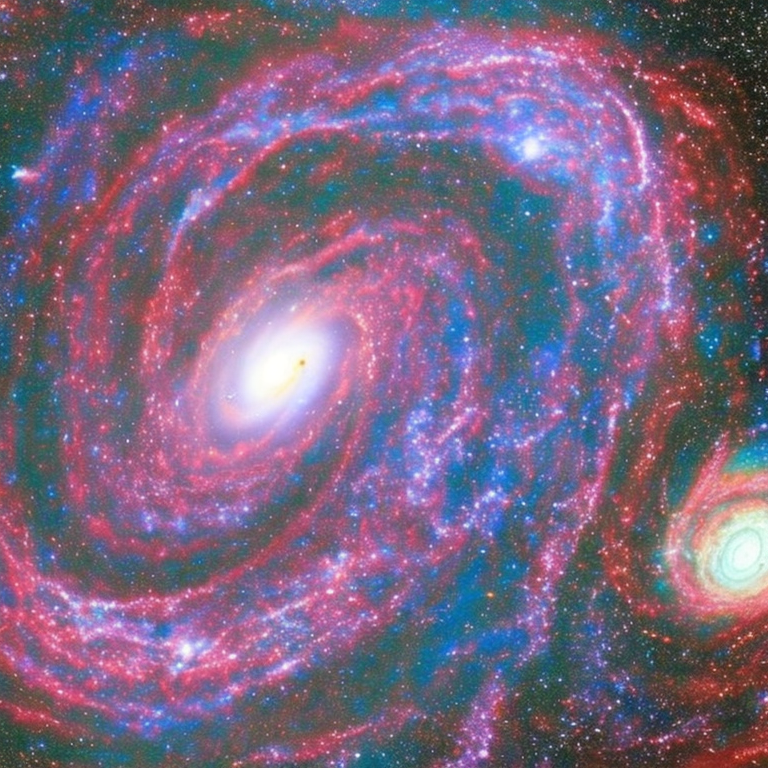

In [39]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from IPython.display import display

# Replace the model version with your required version if needed
pipeline = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2", torch_dtype=torch.float16
)

# Running the inference on GPU with cuda enabled
pipeline = pipeline.to('cuda')

prompt = scene.stable_diffusion_scene_skybox_prompt

images = pipeline(prompt=prompt).images
image = images[0]
image.save('./Unity/AIML Research Project/Assets/background.png')
display(image)

In [41]:
import re
import subprocess
import tempfile
from pathlib import Path

import torch
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.diffusion.sample import sample_latents
from shap_e.models.download import load_config, load_model
from shap_e.util.notebooks import decode_latent_mesh

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xm = load_model("transmitter", device=device)
model = load_model("text300M", device=device)
diffusion = diffusion_from_config(load_config("diffusion"))

batch_size = 1  # this is the size of the models, higher values take longer to generate.
guidance_scale = 15.0  # this is the scale of the guidance, higher values make the model look more like the prompt.

output_dir = Path("./Unity/AIML Research Project/Assets/GLB")
output_dir.mkdir(parents=True, exist_ok=True)

# Generate a safe filename from the prompt
def slugify(text: str) -> str:
    return re.sub(r"[^a-zA-Z0-9\-]+", "-", text.strip().lower()).strip("-")

object_names = set(object.name for object in scene.objects)
print(object_names)

for object_name in object_names:
    base_name = slugify(object_name)
    output_file = output_dir / f"{base_name}.glb"

    print(f"[+] Generating model for prompt: '{object_name}'")
    latents = sample_latents(
        batch_size=batch_size,
        model=model,
        diffusion=diffusion,
        guidance_scale=guidance_scale,
        model_kwargs=dict(texts=[object_name] * batch_size),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_path = Path(tmpdir)
        ply_file = tmp_path / "mesh.ply"

        print(f"[+] Saving intermediate PLY to: {ply_file}")
        t = decode_latent_mesh(xm, latents[0]).tri_mesh()
        with open(ply_file, "wb") as f:
            t.write_ply(f)

        # Call Blender to convert PLY → GLB
        blender_script = Path("./Blender/export.py").resolve()
        command = [
            "blender",
            "-b",
            "-P",
            str(blender_script),
            "--",
            str(ply_file),
            str(output_file),
        ]
        print(f"[+] Running Blender export script...")
        subprocess.run(command, check=True)

    print(f"[✓] Exported: {output_file}")

{'Space Debris', 'Asteroid', 'Spacecraft', 'Satellite', 'Planet'}
[+] Generating model for prompt: 'Space Debris'


  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 